In this Jupyter Notebook, we will provide simulation, statistical tests and optimization of a three-dimensional Hawkes process with an exponential kernel.

The exponential kernel in a multivariate setting takes the form $g^{c,d}(t)=\alpha^{c,d}e^{-\beta^{c,d}t}$.

In [2]:
import os
import sys
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import functools

current_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, current_dir)
import pyhawkes
# pyhawkes_import module just imports pyhawkes.pyd 
# from the main directory of the library 


def ljung_box_test(x, lag):
    n = len(x)
    dex = x - x.mean()
    acf = np.zeros(lag + 1)
    for i in range(lag + 1):
        acf[i] = sum(dex[:(n-i)] * dex[i:n]) / n
    acf = acf / acf[0]
    stat = n * (n + 2) * np.sum((acf[1:lag + 1] ** 2) / np.arange(n - 1, n - lag - 1, - 1))
    lb_test = 1 - scipy.stats.chi2.cdf(stat, lag)
    return lb_test

mu = np.array([0.2, 0.25, 0.15])
alpha = np.array([[0.4, 0.1, 0.1], [0.3, 0.35, 0.4], [0.18, 0.2, 0.31]])
beta = np.array([[1.8, 2.1, 2.5], [1.2, 2, 1.3], [1.4, 0.8, 2.3]])
    
dim = 3
T = 100000
max_jumps = 200000
seed = 123
hawkes = pyhawkes.sim_exp_hawkes(mu, alpha, beta, T, max=max_jumps, rseed=seed)

for i in range(dim):
    print("Number of events in dimension {}: {}".format(i, len(hawkes[i])))
print("")
    
print("Negative Log-likelihood: {}".format(pyhawkes.lik_exp_hawkes(mu, alpha, beta, hawkes, T)))
print("")

comp = pyhawkes.comp_exp_hawkes(mu, alpha, beta, hawkes, T)

for i in range(dim):
    _, p_value = scipy.stats.kstest(comp[i], 'expon', args=(0, 1))
    print("P-value for Kolmogorov-Smirnov test for dimension {}: {}". format(i, p_value))
    comp_var = np.var(comp[i])
    comp_limit = np.sqrt(len(comp[i])) * (comp_var - 1) / np.sqrt(8)
    comp_test = abs(scipy.stats.norm.pdf(comp_limit))
    print("P-value for Excess Dispresion test for dimension {}: {}".format(i, comp_test))
    comp_ljung_box = ljung_box_test(comp[i], lag=20)
    print("P-value for Ljung-Box test  for dimension {}: {}".format(i, comp_ljung_box))
    print("")

Number of events in dimension 0: 30561
Number of events in dimension 1: 53105
Number of events in dimension 2: 37596

Negative Log-likelihood: 211140.3723209708

P-value for Kolmogorov-Smirnov test for dimension 0: 0.37824921532045086
P-value for Excess Dispresion test for dimension 0: 0.24957852487649515
P-value for Ljung-Box test  for dimension 0: 0.13675063974280532

P-value for Kolmogorov-Smirnov test for dimension 1: 0.17695430498703096
P-value for Excess Dispresion test for dimension 1: 0.10645429408458591
P-value for Ljung-Box test  for dimension 1: 0.9461245243519837

P-value for Kolmogorov-Smirnov test for dimension 2: 0.13311079915089338
P-value for Excess Dispresion test for dimension 2: 0.38254698268960075
P-value for Ljung-Box test  for dimension 2: 0.94504279067333



As we can see, all tests are passed on a 5% significance level, so there is little doubt that the process we obtained from the simulation behaves as a Hawkes process. As a qualitative check, we can plot the quantile-quantile plot of the residual process against the exponential distributiuon with rate 1.

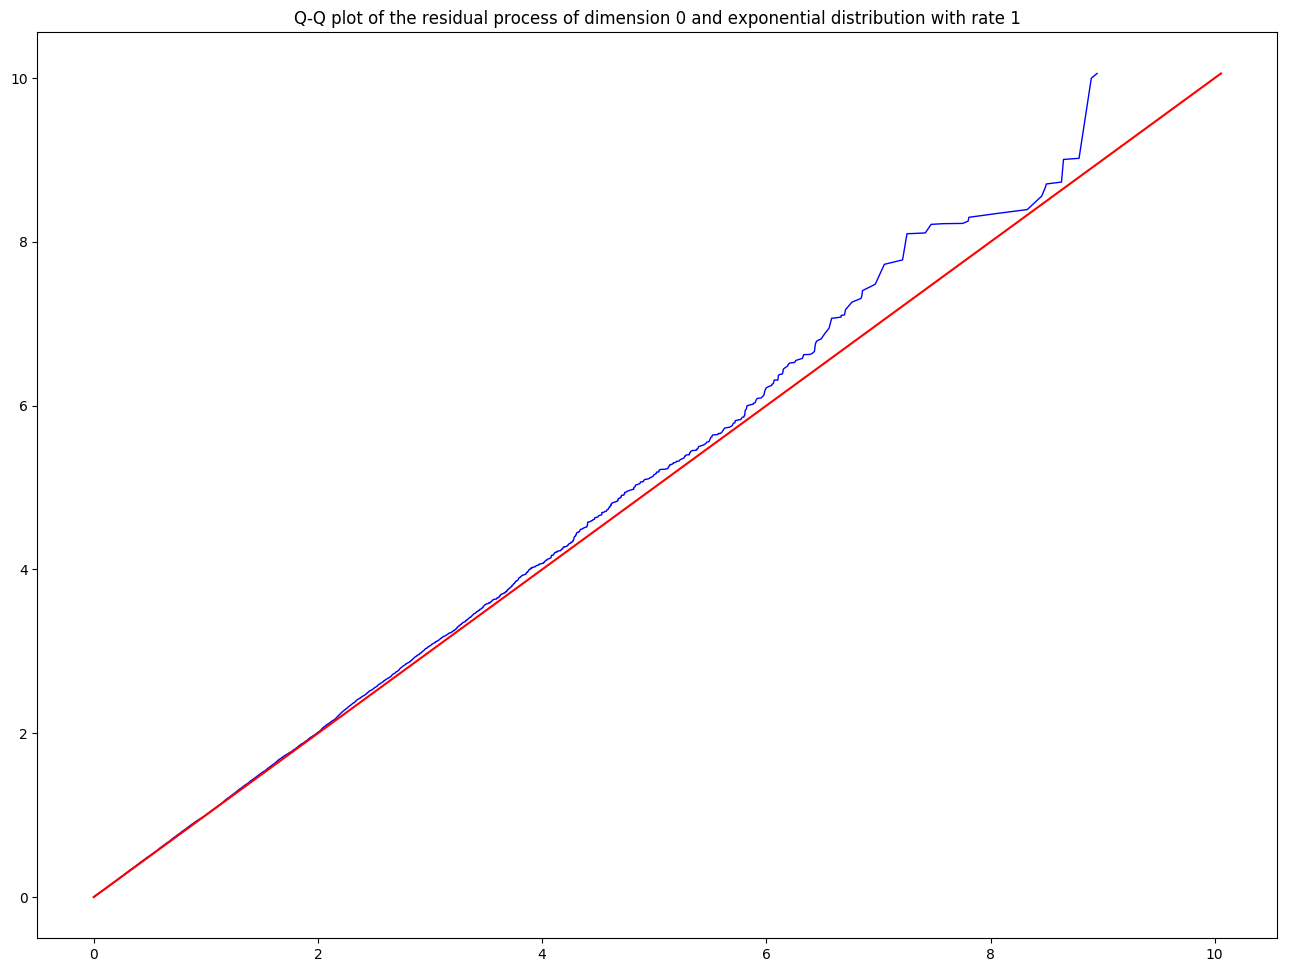

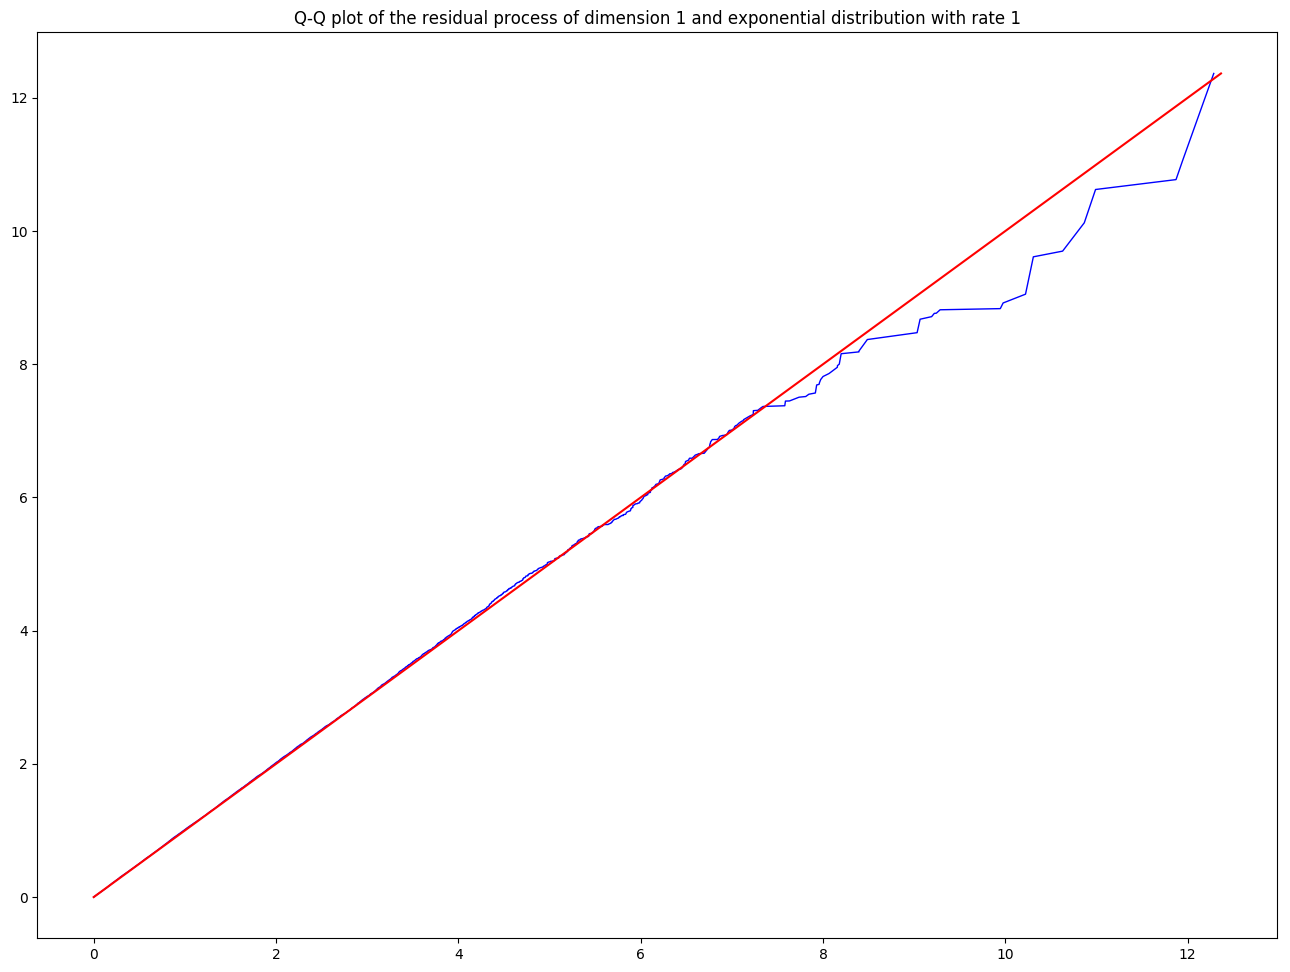

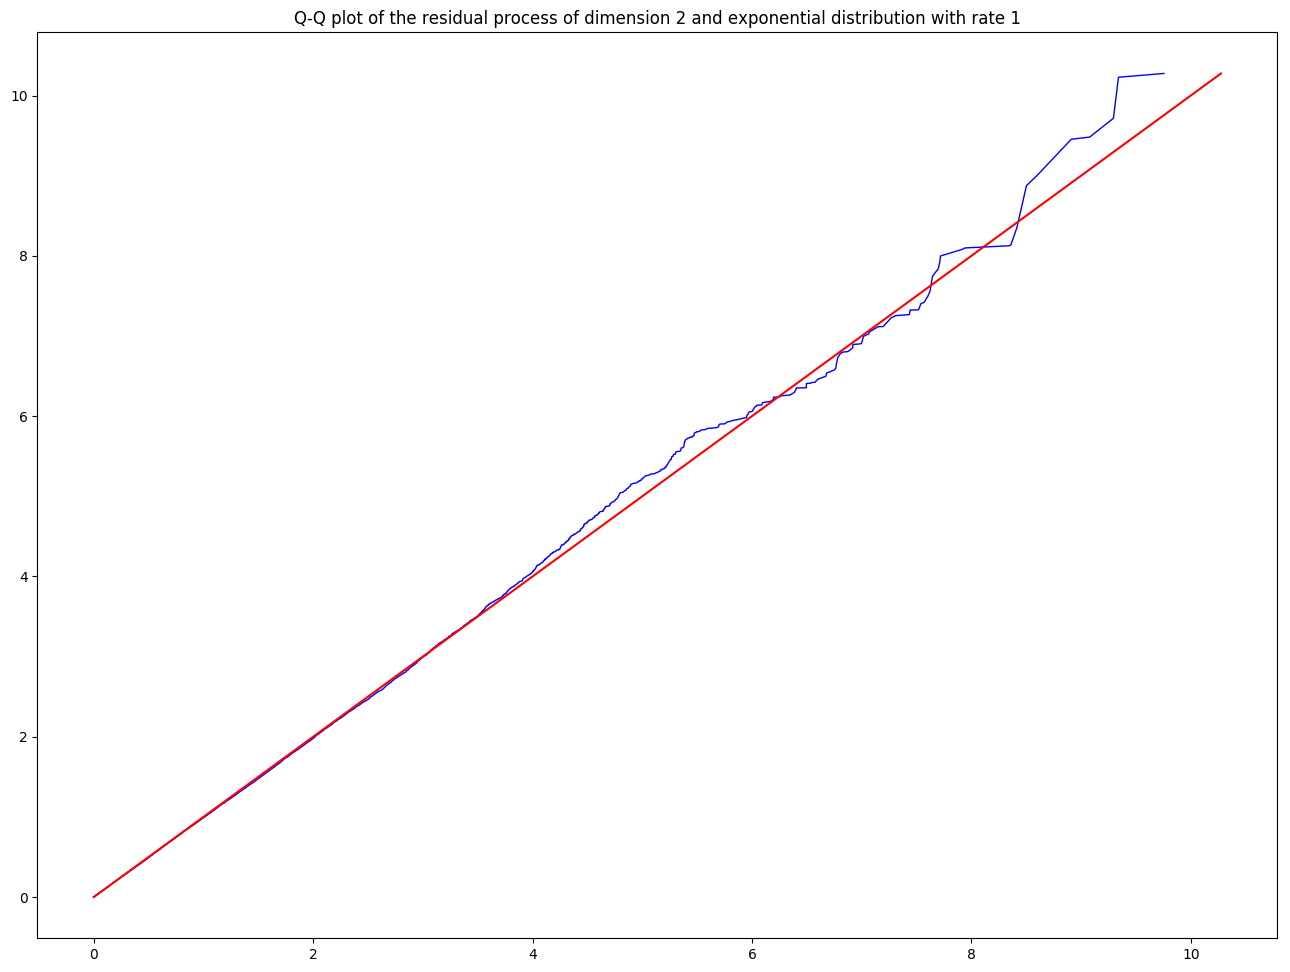

In [3]:
for i in range(dim):
    sorted_comp = sorted(comp[i])
    sorted_exp = np.sort(np.random.exponential(1, len(sorted_comp)))
    a = np.linspace(0, max(sorted_comp[-1], sorted_exp[-1]), len(sorted_comp))
    fig = plt.figure(figsize=(16, 12), dpi=100)
    plt.subplot(1, 1, 1)
    plt.plot(sorted_exp, sorted_comp, color="blue", linewidth=1.0, linestyle="-")
    plt.plot(a, a, color="red")
    plt.title("Q-Q plot of the residual process of dimension {} and exponential distribution with rate 1".format(i))
    plt.show()

We can see that the empirical distribution of residuals closely follows the exponential distribution with rate 1. Now, we will plot the distribution of events for each dimension.

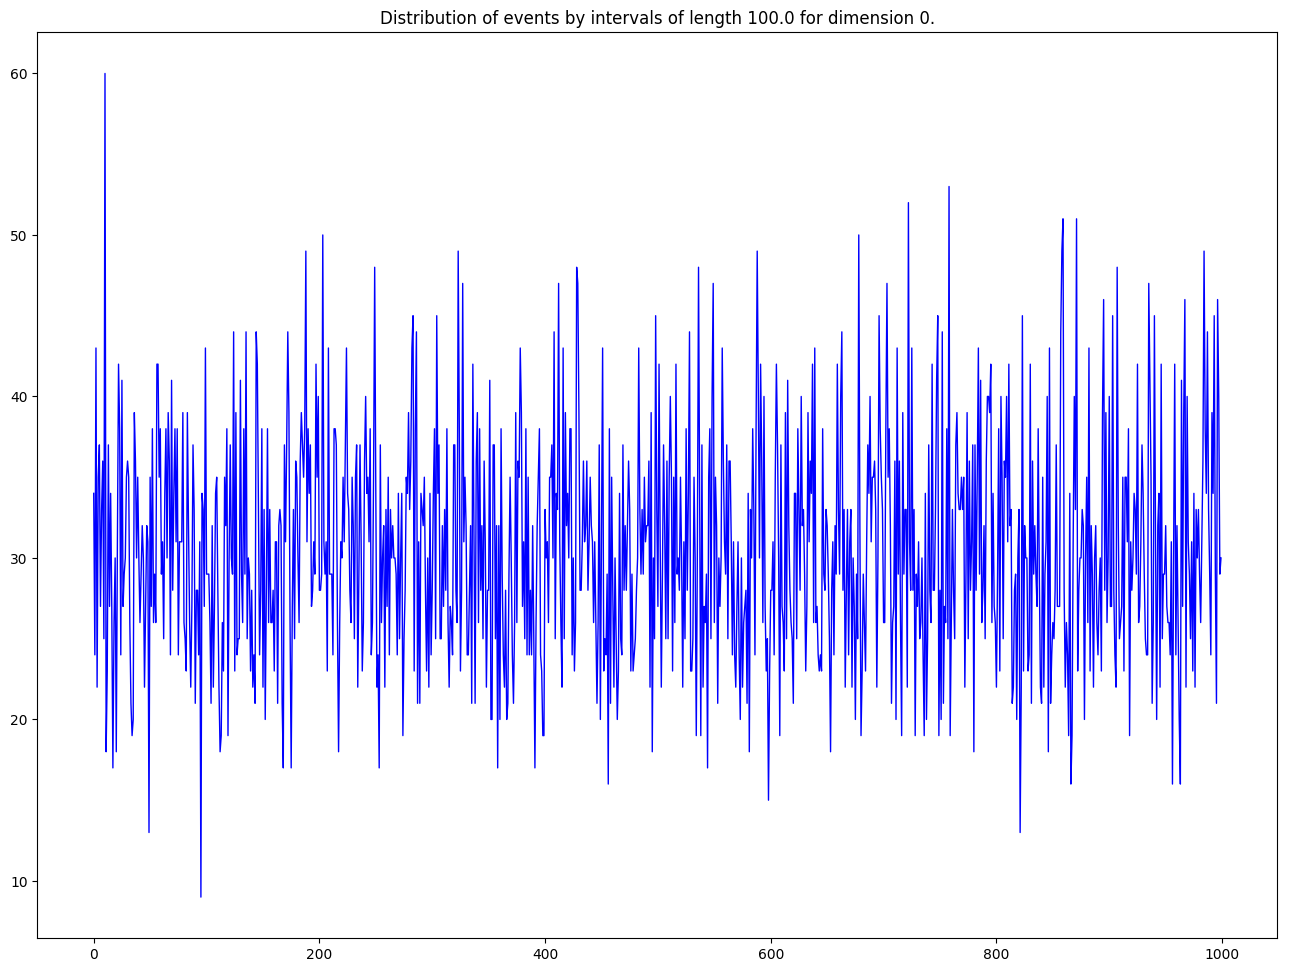

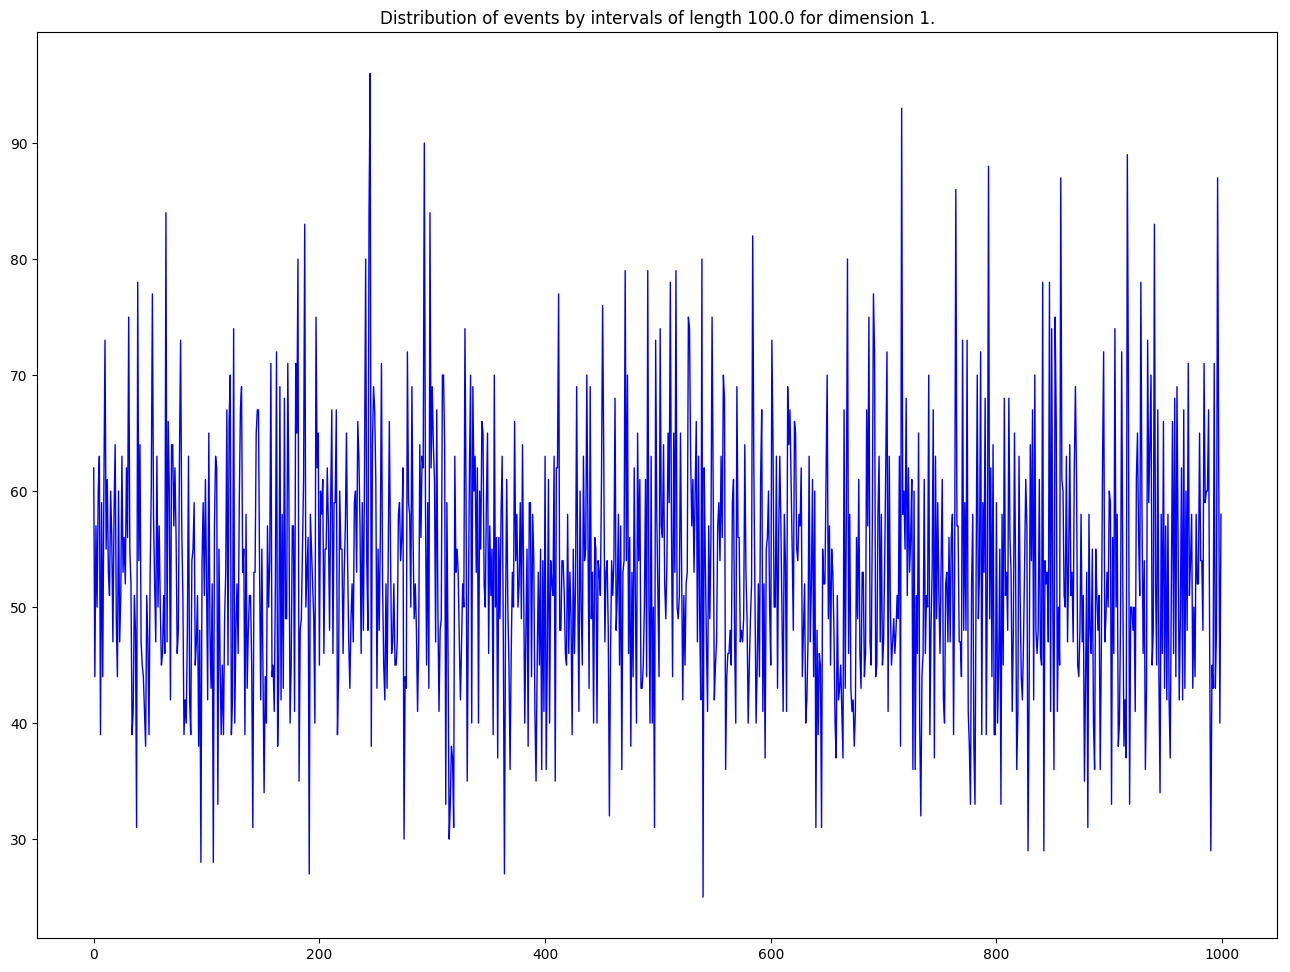

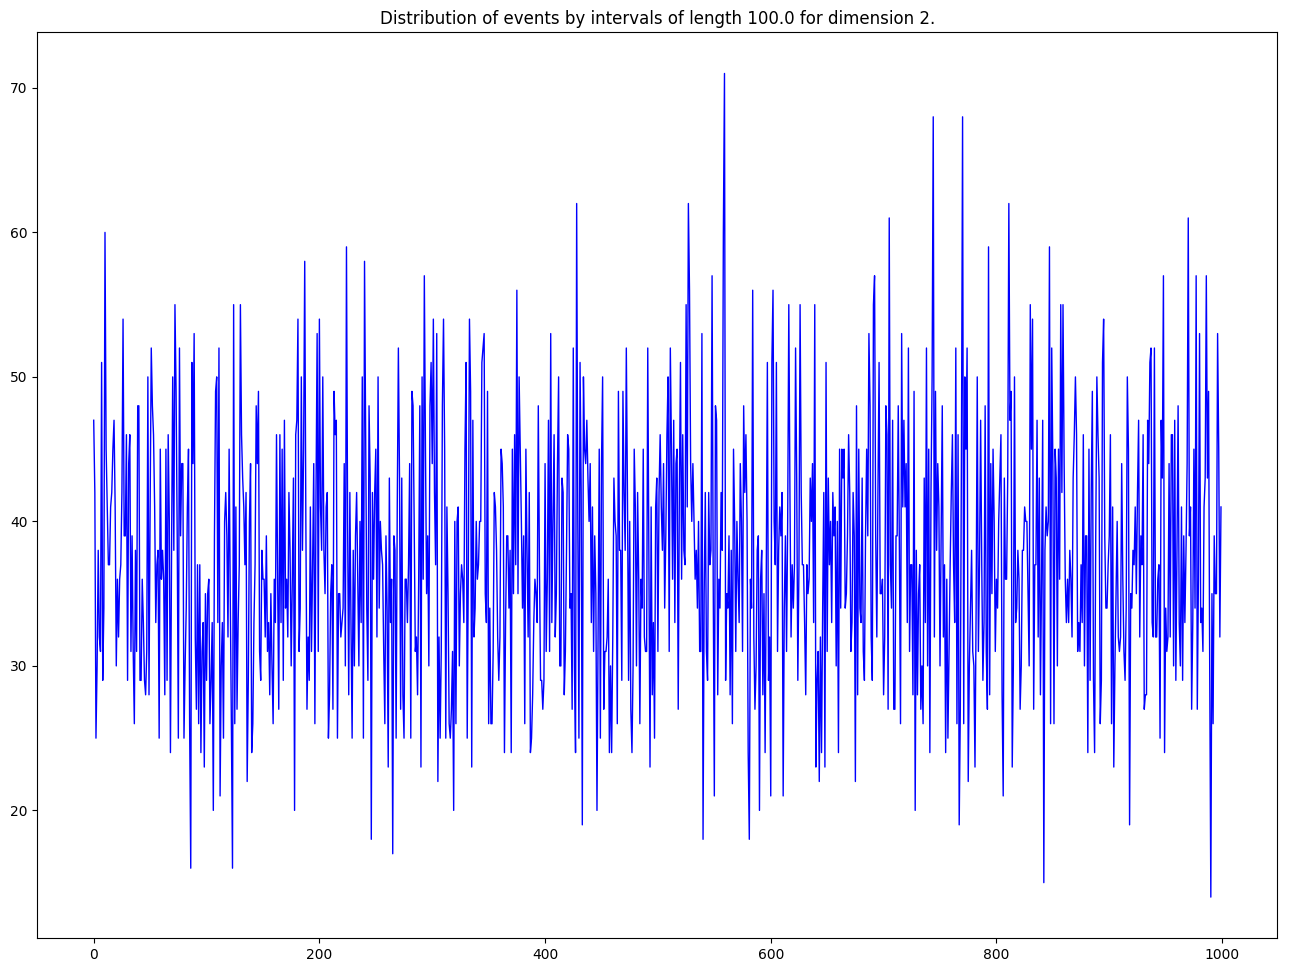

In [4]:
n_points = 1000
evol_hawkes = {i: np.zeros((n_points + 1, 2)) for i in range(dim)}
for i in range(dim):
    evol_hawkes[i][:, 0] = np.linspace(0, n_points, n_points + 1)
for i in range(dim):
    for j in range(len(hawkes[i])):
        index = int(hawkes[i][j] // (T / n_points))
        evol_hawkes[i][index, 1] += 1
for i in range(dim):
    fig = plt.figure(figsize=(16, 12), dpi=100)
    plt.subplot(1, 1, 1)
    plt.plot(evol_hawkes[i][:-1, 0], evol_hawkes[i][:-1, 1], color="blue", linewidth=1.0, linestyle="-",
             label="Number of events")
    plt.title("Distribution of events by intervals of length {} for dimension {}.".format(T / n_points, i))
    plt.show()

And now, lets take a look at conditional intensity functions in an interval [1000, 1020] in a grid of 0.05. That means the conditional intensities will be valued at each 0.05 mark in an interval [1000, 1020], i.e. 1000, 1000.05, 1000.1..., and also at jump times for a given process. Jump timestamps will be plotted below the individual intensity functions.

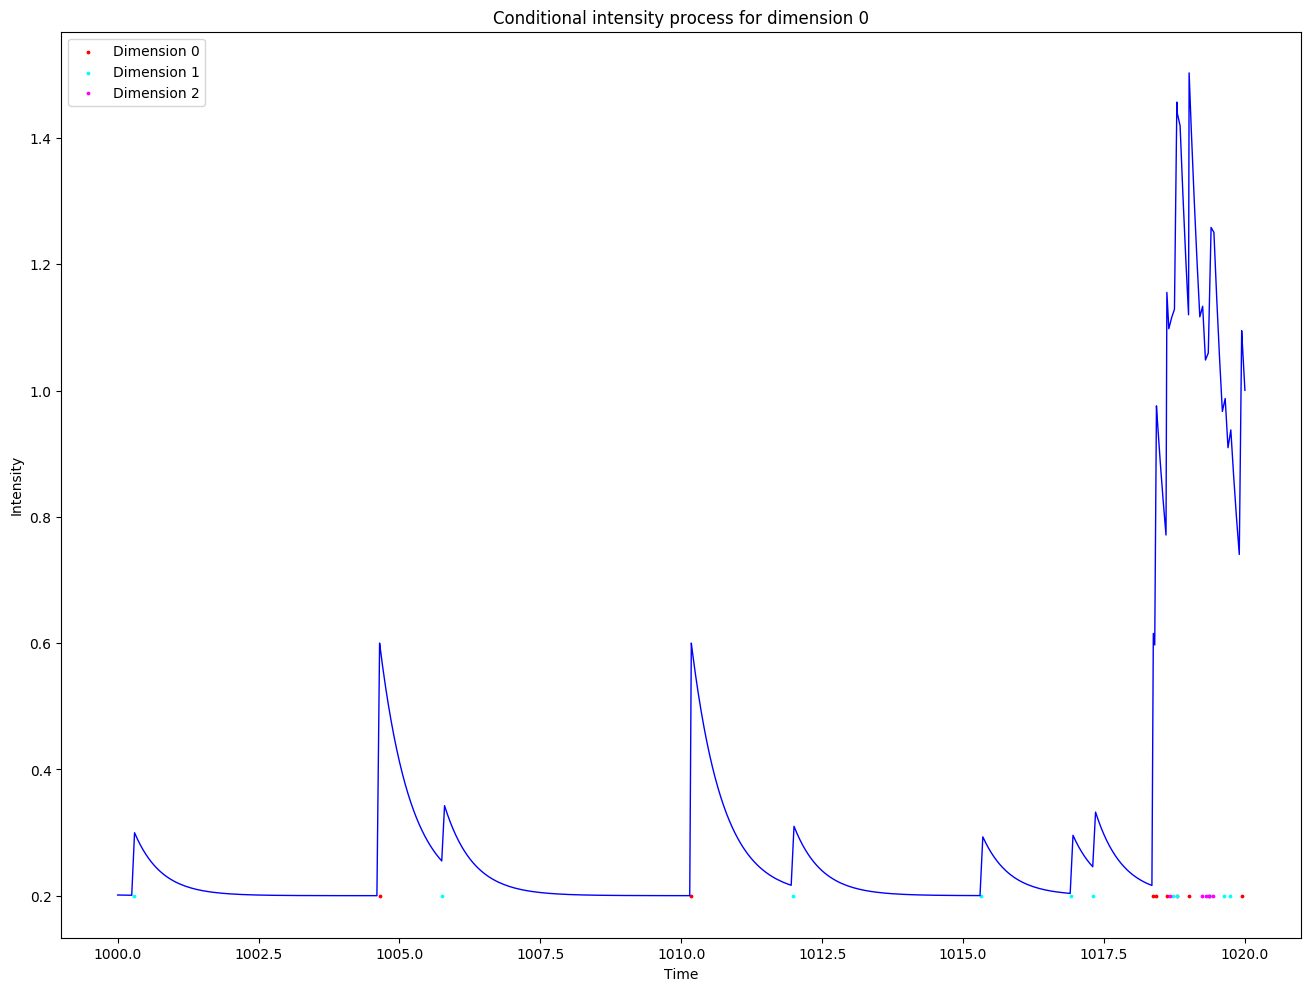

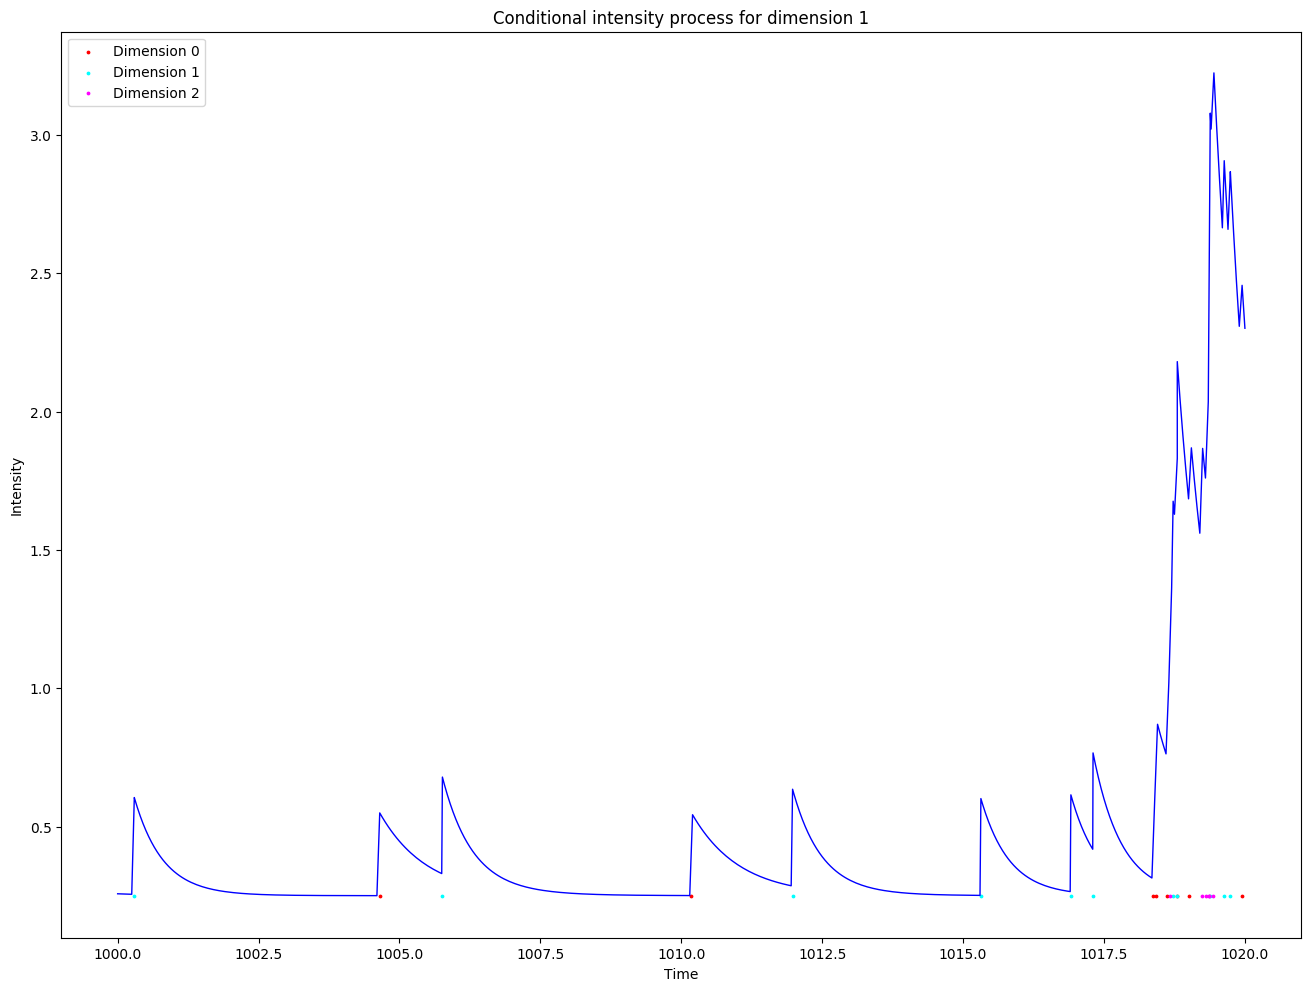

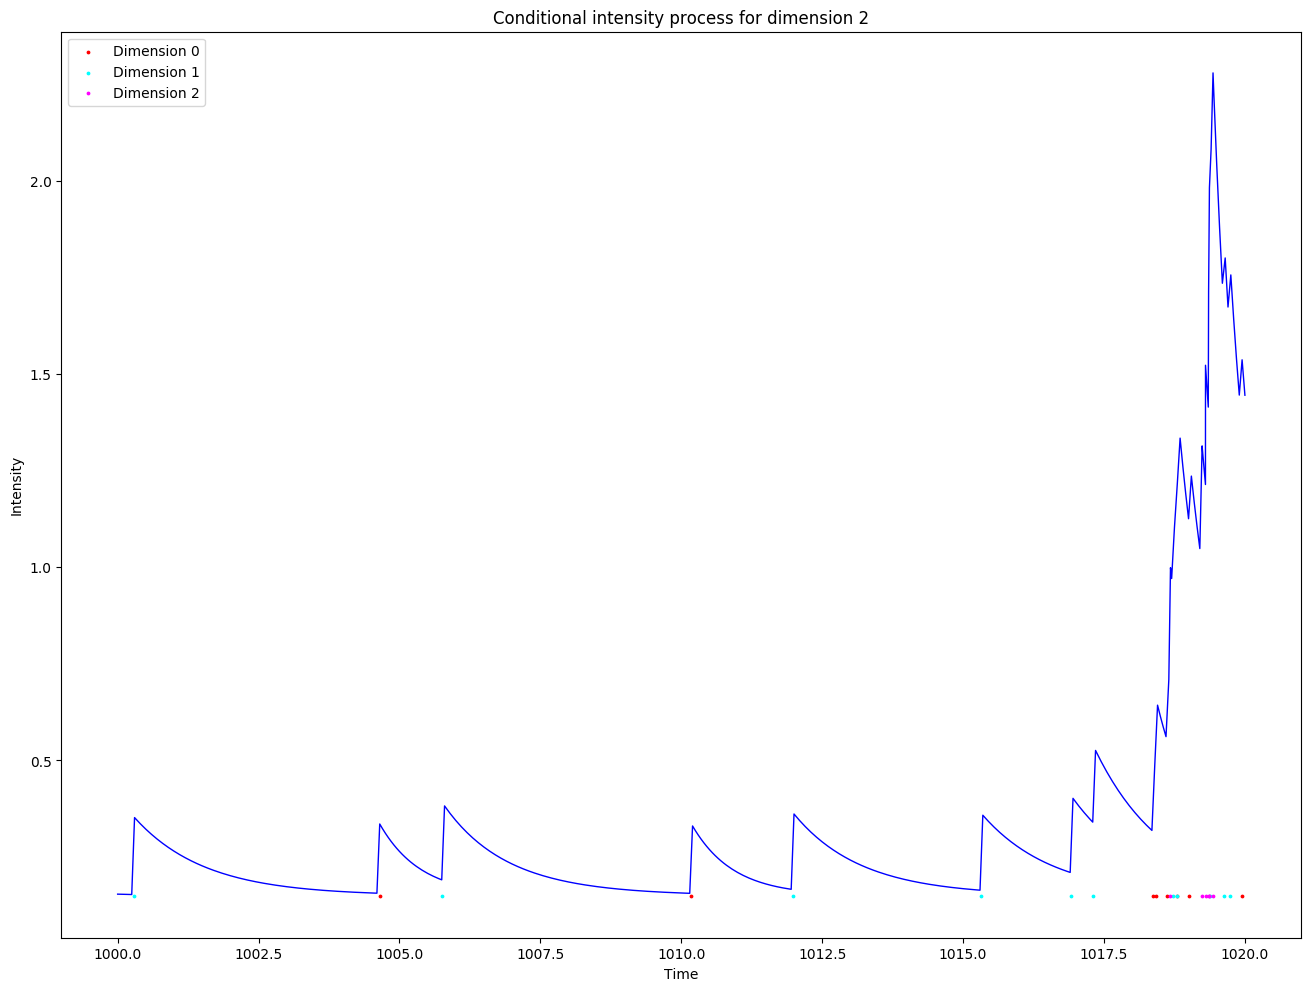

In [5]:
plot_range = (1000, 1020)
grid = 0.05

plt_y, plt_x = pyhawkes.plot_exp_hawkes(mu, alpha, beta, hawkes, T, plot_range[0], plot_range[1], grid)

events = [[] for i in range(dim)]
for i in range(dim):
    j = 0
    while hawkes[i][j] <= plot_range[1]:
        if hawkes[i][j] >= plot_range[0]:
            events[i].append(hawkes[i][j])
        j += 1

for i in range(dim):
    fig = plt.figure(figsize=(16, 12), dpi=100)
    plt.subplot(1, 1, 1)
    plt.plot(plt_x[i], plt_y[i], color="blue", linewidth=1.0, linestyle="-")
    plt.scatter(events[0], [mu[i]] * len(events[0]), color="red", marker="o", s=3, label = "Dimension 0")
    plt.scatter(events[1], [mu[i]] * len(events[1]), color="cyan", marker="o", s=3, label = "Dimension 1")
    plt.scatter(events[2], [mu[i]] * len(events[2]), color="magenta", marker="o", s=3, label = "Dimension 2")
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.title("Conditional intensity process for dimension {}".format(i))
    plt.legend()
    plt.show()

As a final exercise, we might want to see whether we can reliably estimate the parameters of the simulated Hawkes process. We will use scipy SLSQP procedure as it provides bounded and constrained minimization. Bounds will be given arbitrarily by a reasonable guess of an upper bound 20 (lower bound at zero is required by the definition of a Hawkes process) and constraints will impose stationarity condition on the parameters.

In [6]:
n_params = dim + 2*dim**2
upper_bound = 20

def constraint_slsqp(x):
    a = np.array(x[dim:dim + dim**2])
    a.shape = (dim, dim)
    b = np.array(x[dim + dim**2:])
    b.shape = (dim, dim)
    evalues_g, _ = np.linalg.eig(a / b)
    return - np.max(np.abs(evalues_g)) + 1

bounds_slsqp = [(0.000001, upper_bound) for _ in range(n_params)]

niter = 10
i = 0
hawkes_res = np.zeros((n_params, niter), dtype=float)
initial_params = np.zeros((n_params, niter), dtype=float)
fun_values = np.zeros(niter, dtype=float)
msg = np.zeros(niter, dtype=bool)
while i < niter:
    mu_init = np.random.uniform(0, upper_bound, dim)
    alpha_init = np.random.uniform(0, upper_bound, dim**2)
    alpha_init.shape = (dim, dim)
    beta_init = np.random.uniform(0, upper_bound, dim**2)
    beta_init.shape = (dim, dim)
    evalues, _ = np.linalg.eig(alpha_init / beta_init)
    if np.any(np.abs(evalues) >= 1):
        continue
    initial_params[:, i] = np.concatenate((mu_init, np.ndarray.flatten(alpha_init), np.ndarray.flatten(beta_init)))
    partial_est_exp_hawkes = functools.partial(pyhawkes.lik_exp_hawkes_optim, events=hawkes, length=T)
    res = scipy.optimize.minimize(fun=partial_est_exp_hawkes, x0=initial_params[:, i],
                                  method="SLSQP", bounds=bounds_slsqp,
                                  constraints=({'type': 'ineq', 'fun': lambda x: constraint_slsqp(x)}),
                                  options={'maxiter': 20000, 'disp': False, 'ftol': 0.001})
    hawkes_res[:, i] = res.x
    fun_values[i] = res.fun
    msg[i] = res.message
    i += 1

mu_fnl = np.mean(hawkes_res[:dim, :], axis=1)
alpha_fnl = np.mean(hawkes_res[dim:dim + dim**2, :], axis=1)
alpha_fnl.shape = (dim, dim)
beta_fnl = np.mean(hawkes_res[dim + dim**2:, :], axis=1)
beta_fnl.shape = (dim, dim)
evalues, _ = np.linalg.eig(alpha_fnl / beta_fnl)
if np.any(np.abs(evalues) >= 1):
    print("UNSTABLE KERNEL")

print("Original MU: {}".format(mu))
print("Original ALPHA: {}".format(alpha))
print("Original BETA: {}".format(beta))
print("")

print("Mean of estimated MU: {}".format(mu_fnl))
print("Mean of estimated ALPHA: {}".format(alpha_fnl))
print("Mean of estimated BETA: {}".format(beta_fnl))
print("")

print("Mean of negative log-likelihood: {}".format(fun_values.mean()))
print("")

print("Success rate: {}".format(msg.mean()))

Original MU: [0.2  0.25 0.15]
Original ALPHA: [[0.4  0.1  0.1 ]
 [0.3  0.35 0.4 ]
 [0.18 0.2  0.31]]
Original BETA: [[1.8 2.1 2.5]
 [1.2 2.  1.3]
 [1.4 0.8 2.3]]

Mean of estimated MU: [0.16024849 0.2623504  0.11938004]
Mean of estimated ALPHA: [[0.37858644 0.13411435 0.07706668]
 [0.23906262 0.27913344 0.37809963]
 [0.14923961 0.16498934 0.24880112]]
Mean of estimated BETA: [[5.37893364 5.57639294 6.04202801]
 [4.95616092 5.51188801 5.01469368]
 [5.10110945 4.65068551 5.76623181]]

Mean of negative log-likelihood: 295680.9699758485

Success rate: 1.0


We can notice that the estimation is very sensible for $\alpha$ and $\mu$ parameters even for 10 iterations. However, we may observe that $\beta$ values are much harder to estimate properly. Better initial estimates or more iterations might be of help in this case.